# Importing Libraries and Data

<font color='blue'>Cell 1
Importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<font color='blue'>Cell 2
Reading the data

* dividend: Binary indicator of whether the stock pays dividend.
* fcfps: Represents the free cash flow per share, how much cash a company generates relative to its share count.
* earnings_growth: Percentage growth in earnings.
* de: Debt to equity ratio. Indicates company's financial leverage and is a measure of the degree to which a company is financing its operations through debt
* mcap: Market capitalization.
* current_ratio: Liquidity ratio that measures a company's ability to pay short-term obligations with its current assets.

In [2]:
dividend_data = pd.read_csv("dividendinfo.csv")
dividend_data.head()

,dividend,fcfps,earnings_growth,de,mcap,current_ratio
0,0,2.75,-19.25,1.11,545,0.924056
1,1,4.96,0.83,1.09,630,1.468572
2,1,2.78,1.09,0.19,562,1.975875
3,0,0.43,12.97,1.70,388,1.941998
4,1,2.94,2.44,1.83,684,2.487467


In [3]:
#Check the dataset to make sure no data is missing and Check the class labels
def verify_dataset(data):
  #if any of the rows have missing value return datas missing
  data_found = 1
  for each_column in data.columns:
    if data[each_column].isnull().any():
            print("Data missing in Column " + each_column)
            #if any rows are not missing return Dataset is complete. No missing value
            quit()
    if data_found == 1:
        print("Dataset is complete. No missing values")
    return

verify_dataset(dividend_data)

Dataset is complete. No missing values


<font color='blue'>Cell 4
One hot encoding function

In [4]:
#This function accepts an array of categorical variables and returns the one hot encoding
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized


<font color='blue'>Cell 5
Data normalization function

In [5]:
#Normalize array
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

<font color='blue'>Cell 6
Activation function definitions

In [6]:
#sigmoid and its derivative
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1 - sigmoid(x))

def user_softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

<font color='blue'>Cell 7
Selecting features from a list

In [7]:
'''Change the values below'''
fcfps = True
earnings_growth = True
de = True
mcap	 = True
current_ratio = True
'''Change the values above'''

feature_list = [fcfps, earnings_growth, de, mcap, current_ratio]

<font color='blue'>Cell 8
Selecting features and running the normalization function

In [8]:
#Specifying the input data "x"
columns = ['fcfps', 'earnings_growth', 'de', 'mcap', 'current_ratio']
x = pd.DataFrame(dividend_data, columns=columns)
x = x.to_numpy()
x = x[:,feature_list]
x = normalize(x)

<font color='blue'>Cell 9
Labelling output data and applying one hot encoding

In [9]:
#Replace the species with 1,2 or 3 as appropriate
label_dict = dict()
label_dict['0'] = '0'
label_dict['1'] = '1'
dividend_data['dividend'].replace(['0', '1'], [0, 1], inplace=True)

#Get Output, flatten and encode to one-hot
columns = ['dividend']

y = pd.DataFrame(dividend_data, columns=columns)
y = y.to_numpy()
y = y.flatten()
y = to_one_hot(y)


<font color='blue'>Cell 10
Train test splitting

In [10]:
x_y = pd.DataFrame(np.concatenate((x,y), axis=1))
def split_dataset_test_train(data,train_size):
  data = data.sample(frac=1).reset_index(drop=True)
  training_data = data.iloc[:int(train_size * len(data))].reset_index(drop=True)
  testing_data = data.iloc[int(train_size * len(data)):].reset_index(drop=True)
  return [training_data, testing_data]

train_test_data = split_dataset_test_train(x_y,0.7)
X_train = train_test_data[0].iloc[:,0:5].to_numpy()
X_test = train_test_data[1].iloc[:,0:5].to_numpy()

y_train = train_test_data[0].iloc[:,-1:].to_numpy()
y_test = train_test_data[1].iloc[:,-1:].to_numpy()

<font color='blue'>Cell 11
Training function definition

In [11]:
def training(X_train, y_train, lr, batch_size, epochs, hidden_size):
    np.random.seed(42)  # For reproducibility

    w0 = 2 * np.random.random((X_train.shape[1], hidden_size)) - 1
    w1 = 2 * np.random.random((hidden_size, 1)) - 1  # Output layer has 1 neuron for binary classification

    bh = np.random.randn(hidden_size)
    bo = np.random.randn(1)

    num_samples = len(X_train)
    num_batch = (num_samples + batch_size - 1) // batch_size  # Ceiling division

    errors = []

    for epoch in range(epochs):
        for curr_batch in range(num_batch):
            batch_start = curr_batch * batch_size
            batch_end = min(batch_start + batch_size, num_samples)
            input_batch = X_train[batch_start:batch_end]
            labels_batch = y_train[batch_start:batch_end]

            # Forward propagation
            zh = np.dot(input_batch, w0) + bh
            layer1 = sigmoid(zh)

            zo = np.dot(layer1, w1) + bo
            layer2 = sigmoid(zo)

            # Backpropagation
            layer2_error = layer2 - labels_batch.reshape(-1, 1)
            layer2w_delta = np.dot(layer1.T, layer2_error)
            layer2b_delta = layer2_error

            dcost_dah = np.dot(layer2_error, w1.T)
            dah_dzh = sigmoid_deriv(zh)
            layer1_error = dah_dzh * dcost_dah
            layer1w_delta = np.dot(input_batch.T, layer1_error)
            layer1b_delta = layer1_error

            # Update Weights and Biases
            w0 -= lr * layer1w_delta
            bh -= lr * layer1b_delta.sum(axis=0)

            w1 -= lr * layer2w_delta
            bo -= lr * layer2b_delta.sum(axis=0)

        error = np.mean(np.abs(layer2_error))
        errors.append(error)

    return [w0, bh, w1, bo], error, errors

<font color='blue'>Cell 12
Evaluation function definition

In [12]:
def evaluation(params, tst_set):
    w0, bh, w1, bo = params

    # Forward propagation
    zh = np.dot(tst_set, w0) + bh
    layer1 = sigmoid(zh)

    zo = np.dot(layer1, w1) + bo
    layer2 = sigmoid(zo)

    return layer2

# Exercise 3.2

<font color='blue'>Cell 13
Selecting parameters and running the training function

In [ ]:
trained_params, error, errors = training(X_train, 
                                         y_train, 
                                         lr = 0.01, 
                                         batch_size = 16, 
                                         epochs = 100000, 
                                         hidden_size = 10)

<font color='blue'>Cell 14
Displaying the errors from training

In [ ]:
# Plot the accuracy chart
accuracy = (1 - error) * 100

plt.plot(errors)
plt.xlabel('Training', fontsize=20)  # Adjust font size as needed
plt.ylabel('Error', fontsize=20)  # Adjust font size as needed

# Set title and tick label sizes if needed
plt.title('Training Error Over Epochs', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()

print("Training Accuracy " + str(round(accuracy, 2)) + "%")


<font color='blue'>Cell 15
Running the evaluation function

<font color='blue'>Cell 16
Displaying the confusion matrix

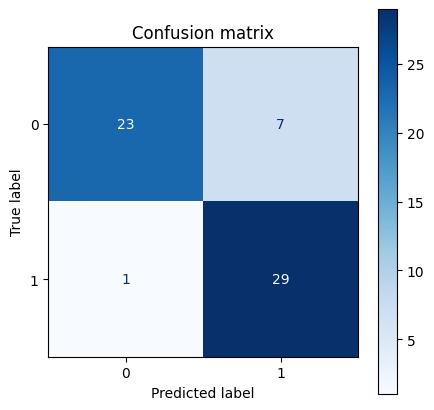


Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.77      0.85        30
         1.0       0.81      0.97      0.88        30

    accuracy                           0.87        60
   macro avg       0.88      0.87      0.87        60
weighted avg       0.88      0.87      0.87        60



In [15]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

y_pred = (evaluation(trained_params,X_test) > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred) 
cmp = ConfusionMatrixDisplay(confusion_matrix= cm)

fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax, cmap = plt.cm.Blues)


plt.title("Confusion matrix")
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Exercise 3.1

<font color='blue'>Cell 17
Function for testing flower dimensions

In [16]:
dividend_data

,dividend,fcfps,earnings_growth,de,mcap,current_ratio
0,0,2.75,-19.25,1.11,545,0.924056
1,1,4.96,0.83,1.09,630,1.468572
2,1,2.78,1.09,0.19,562,1.975875
3,0,0.43,12.97,1.70,388,1.941998
4,1,2.94,2.44,1.83,684,2.487467
...,...,...,...,...,...,...
195,1,1.16,37.26,2.47,404,1.077471
196,1,3.77,16.33,0.26,760,2.483898
197,0,1.30,24.69,3.60,236,1.045505
198,0,1.60,-11.59,3.00,387,0.437697


In [52]:
def input_test_seq():
    
    fcfps = float(input('Enter the fcfps, free cash flow per share:'))
    while True:
        if float(fcfps) < 0:
            print('Inalid Entry. Enter fcfps > 0 \n')
            sepal_length = float(input('Enter the fcfps:'))
            continue
        else:
            break

    earnings_growth	 = float(input('Enter the earnings_growth:'))


    de = float(input('Enter the de, the detb to equity ratio:'))
    
    while True:
        if float(de) < 0 :
            print('Invalid Entry. Please enter a positive value.')
            de = float(input('Enter the de:'))
            continue
        else:
            break

    mcap = float(input('Enter the mcap, the market capitalization:'))
    while True:
        if float(mcap) < 0 :
            print('Invalid entry. Please enter a positive value.')
            mcap = float(input('Enter the mcap:'))
            continue
        else:
            break

    current_ratio = float(input('Enter the current_ratio, liquidity ratio:'))
    while True:
        if float(current_ratio) < 0 :
            print('Invalid entry. Please enter a positive value.')
            current_ratio = float(input('Enter the current_ratio:'))
            continue
        else:
            break
            

    predict_features = [fcfps, earnings_growth, de, mcap, current_ratio]
    predict_features = normalize(predict_features)
    result_category = evaluation(trained_params,predict_features)
    result_category = np.round(result_category)

    if result_category == 0:
        value_prediction = "NOT PAY dividends"
    elif result_category == 1:
        value_prediction = "PAY dividends"
    return value_prediction

dividend_prediction = input_test_seq()
print("The stock is most likely to:", dividend_prediction)

Enter the fcfps, free cash flow per share: 10
Enter the earnings_growth: 20
Enter the de, the detb to equity ratio: 0.1
Enter the mcap, the market capitalization: 2000
Enter the current_ratio, liquidity ratio: 100


The stock is most likely to: PAY dividends
